# Perturbation experiment

**Goal of the experiment:** silence or randomize one set of coordinates (Cartesian/polar) to see the effects

Potential metrics:
- performance histogram
- % correct
- shift in behavior
- Steps number

## Init

In [1]:
from pathlib import Path
import torch
import torch.optim as optim
import torch.nn as nn
from collections import deque, namedtuple
from tqdm.auto import tqdm

# from utils import make_deterministic, random_choice
from agent import EpsilonGreedy, neural_network
import utils
from environment import CONTEXTS_LABELS, Actions, Cues, DuplicatedCoordsEnv
import plotting as viz

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Experiment params

In [3]:
keep = "cartesian"
# keep = "polar"
silence = True
# silence = False

In [4]:
total_episodes = 100

## Load data

In [5]:
save_path = Path("..") / "save"
save_path.exists()

True

In [6]:
data_dir = save_path / "2025-03-08_01-44-12_EastWest_save-all-agents"
# data_dir = save_path / "2025-03-08_01-47-50_LeftRight_save-all-agents"
data_dir.exists()

True

In [7]:
data_path = data_dir / "data.tar"
data_path.exists()

True

In [8]:
model_path = data_dir / "trained-agent-state-0.pt"
model_path.exists()

True

In [9]:
data_dict = torch.load(data_path, weights_only=False, map_location=DEVICE)

# Access individual arrays by their names
p = data_dict["p"]
env = data_dict["env"]
net = data_dict["net"]


## Inference loop

In [10]:
def ablate_state(state, keep, silence=True):
    new_state = state
    if keep == "cartesian":
        idx = torch.arange(start=9, end=19, device=DEVICE)
    elif keep == "polar":
        idx = torch.arange(start=1, end=9, device=DEVICE)
    else:
        raise ValueError("The state to keep can only be either 'polar' or 'cartesian'")
    if silence:
        repl_val = 0
    else:
        if len(state.shape) > 1:
            repl_val = torch.rand((state.shape[0], len(idx)), device=DEVICE)
        else:
            repl_val = torch.rand(len(idx), device=DEVICE)
    if len(state.shape) > 1:
        new_state[:, idx] = repl_val
    else:
        new_state[idx] = repl_val
    return new_state

In [11]:
# state = env.reset()  # Reset the environment
# state = state.clone().float().detach().to(DEVICE)
# state

In [12]:
# ablate_state(state=state, keep=keep, silence=silence)

In [13]:
# state_batch = torch.tile(state, (3,1))
# state_batch

In [14]:
# ablate_state(state=state_batch, keep=keep, silence=silence)

In [15]:
episodes = torch.arange(total_episodes, device=DEVICE).to(dtype=torch.int)
replay_buffer = deque([], maxlen=p.replay_buffer_max_size)

In [16]:
Transition = namedtuple(
    "Transition", ("state", "action", "reward", "next_state", "done")
)

In [17]:
net, _ = neural_network(
    n_observations=p.n_observations,
    n_actions=p.n_actions,
    nHiddenUnits=p.n_hidden_units,
)  # Reset weights

In [18]:
# Load trained state from data
trained_state_dict = torch.load(model_path, weights_only=True, map_location=DEVICE)
net.load_state_dict(trained_state_dict)
# target_net.load_state_dict(trained_state_dict)

<All keys matched successfully>

In [19]:
# optimizer = optim.AdamW(net.parameters(), lr=p.alpha, amsgrad=True)
explorer = EpsilonGreedy(
    epsilon=p.epsilon_max,
    epsilon_min=p.epsilon_min,
    epsilon_max=p.epsilon_max,
    decay_rate=p.decay_rate,
    epsilon_warmup=p.epsilon_warmup,
)

In [20]:
p.epsilon_min

0.1

In [21]:
explorer.epsilon = p.epsilon_min
explorer.epsilon

0.1

In [22]:
n_runs = 1
run = 0
rewards = torch.zeros((total_episodes, n_runs), device=DEVICE)
steps = torch.zeros((total_episodes, n_runs), device=DEVICE)

In [23]:
for episode in tqdm(episodes):
    state = env.reset()  # Reset the environment
    state = state.clone().float().detach().to(DEVICE)
    step_count = 0
    done = False
    total_rewards = 0
    loss = torch.ones(1, device=DEVICE) * torch.nan
    
    while not done:
        state_action_values = net(ablate_state(state=state, keep=keep, silence=silence)).to(DEVICE)  # Q(s_t)
        action = explorer.choose_action(
            action_space=env.action_space,
            state=state,
            state_action_values=state_action_values,
        ).item()
    
        # # Record states and actions
        # all_states[run][episode].append(state.cpu())
        # all_actions[run][episode].append(Actions(action).name)
    
        next_state, reward, done = env.step(action=action, current_state=state)
    
        # Store transition in replay buffer
        # [current_state (2 or 28 x1), action (1x1), next_state (2 or 28 x1),
        # reward (1x1), done (1x1 bool)]
        done = torch.tensor(done, device=DEVICE).unsqueeze(-1)
        replay_buffer.append(
            Transition(
                state,
                action,
                reward,
                next_state,
                done,
            )
        )
    
        # # Start training when `replay_buffer` is full
        # if len(replay_buffer) == p.replay_buffer_max_size:
        #     transitions = utils.random_choice(
        #         replay_buffer,
        #         length=len(replay_buffer),
        #         num_samples=p.batch_size,
        #         generator=None,
        #     )
        #     batch = Transition(*zip(*transitions, strict=True))
        #     state_batch = torch.stack(batch.state)
        #     action_batch = torch.tensor(batch.action, device=DEVICE)
        #     reward_batch = torch.cat(batch.reward)
        #     # next_state_batch = torch.stack(batch.next_state)
        #     # done_batch = torch.cat(batch.done)
    
        #     # See DQN paper for equations: https://doi.org/10.1038/nature14236
        #     state_action_values_sampled = net(ablate_state(state=state_batch, keep=keep, silence=silence)).to(DEVICE)  # Q(s_t)
        #     state_action_values = torch.gather(
        #         input=state_action_values_sampled,
        #         dim=1,
        #         index=action_batch.unsqueeze(-1),
        #     ).squeeze()  # Q(s_t, a)
    
        #     # Compute a mask of non-final states and concatenate
        #     # the batch elements
        #     # (a final state would've been the one after which simulation ended)
        #     non_final_mask = torch.tensor(
        #         tuple(map(lambda s: not s, batch.done)),
        #         device=DEVICE,
        #         dtype=torch.bool,
        #     )
        #     non_final_next_states = torch.stack(
        #         [s[1] for s in zip(batch.done, batch.next_state) if not s[0]]
        #     )
    
        #     # Compute V(s_{t+1}) for all next states.
        #     # Expected values of actions for non_final_next_states are computed
        #     # based on the "older" target_net;
        #     # selecting their best reward with max(1).values
        #     # This is merged based on the mask,
        #     # such that we'll have either the expected
        #     # state value or 0 in case the state was final.
        #     next_state_values = torch.zeros(p.batch_size, device=DEVICE)
        #     if non_final_next_states.numel() > 0 and non_final_mask.numel() > 0:
        #         with torch.no_grad():
        #             next_state_values[non_final_mask] = (
        #                 target_net(ablate_state(state=non_final_next_states, keep=keep, silence=silence)).max(1).values
        #             )
        #     # Compute the expected Q values
        #     expected_state_action_values = reward_batch + (
        #         next_state_values * p.gamma
        #     )
    
        #     # Compute loss
        #     # criterion = nn.MSELoss()
        #     criterion = nn.SmoothL1Loss()
        #     loss = criterion(
        #         input=state_action_values,  # prediction
        #         target=expected_state_action_values,  # target/"truth" value
        #     )  # TD update
    
        #     # Optimize the model
        #     optimizer.zero_grad()
        #     loss.backward()
        #     torch.nn.utils.clip_grad_value_(
        #         net.parameters(), 100
        #     )  # In-place gradient clipping
        #     optimizer.step()
    
        #     # # Reset the target network
        #     # if step_count % p.target_net_update == 0:
        #     #     target_net.load_state_dict(net.state_dict())
    
        #     # Soft update of the target network's weights
        #     # θ′ ← τ θ + (1 −τ )θ′
        #     target_net_state_dict = target_net.state_dict()
        #     net_state_dict = net.state_dict()
        #     for key in net_state_dict:
        #         target_net_state_dict[key] = net_state_dict[
        #             key
        #         ] * p.tau + target_net_state_dict[key] * (1 - p.tau)
        #     target_net.load_state_dict(target_net_state_dict)
    
        #     # losses[run].append(loss.item())
    
        #     # weights, biases = utils.collect_weights_biases(net=net)
        #     # weights_val_stats = utils.params_df_stats(
        #     #     weights, key="val", current_df=weights_grad_stats
        #     # )
        #     # biases_val_stats = utils.params_df_stats(
        #     #     biases, key="val", current_df=biases_val_stats
        #     # )
        #     # biases_grad_stats = utils.params_df_stats(
        #     #     biases, key="grad", current_df=biases_grad_stats
        #     # )
        #     # weights_grad_stats = utils.params_df_stats(
        #     #     weights, key="grad", current_df=weights_val_stats
        #     # )
    
        total_rewards += reward
        step_count += 1
    
        # Move to the next state
        state = next_state
    
        explorer.epsilon = explorer.update_epsilon(episode)
    #     epsilons.append(explorer.epsilon)
    
    # all_states[run][episode].append(state.cpu())
    rewards[episode, run] = total_rewards
    steps[episode, run] = step_count
    # logger.info(
    #     f"Run: {run + 1}/{p.n_runs} - Episode: {episode + 1}/{p.total_episodes}"
    #     f" - Steps: {step_count} - Loss: {loss.item()}"
    #     f" - epsilon: {explorer.epsilon}"
    # )

  0%|          | 0/100 [00:00<?, ?it/s]

## Vizualization

In [24]:
rew_steps_df = utils.postprocess_rewards_steps(
    episodes=episodes, n_runs=n_runs, rewards=rewards, steps=steps
)
rew_steps_df

,Episodes,Rewards,Steps
0,0,0.0,1082.0
1,1,1.0,37.0
2,2,1.0,174.0
3,3,0.0,220.0
4,4,1.0,12.0
...,...,...,...
95,95,1.0,244.0
96,96,1.0,2248.0
97,97,1.0,536.0
98,98,1.0,226.0


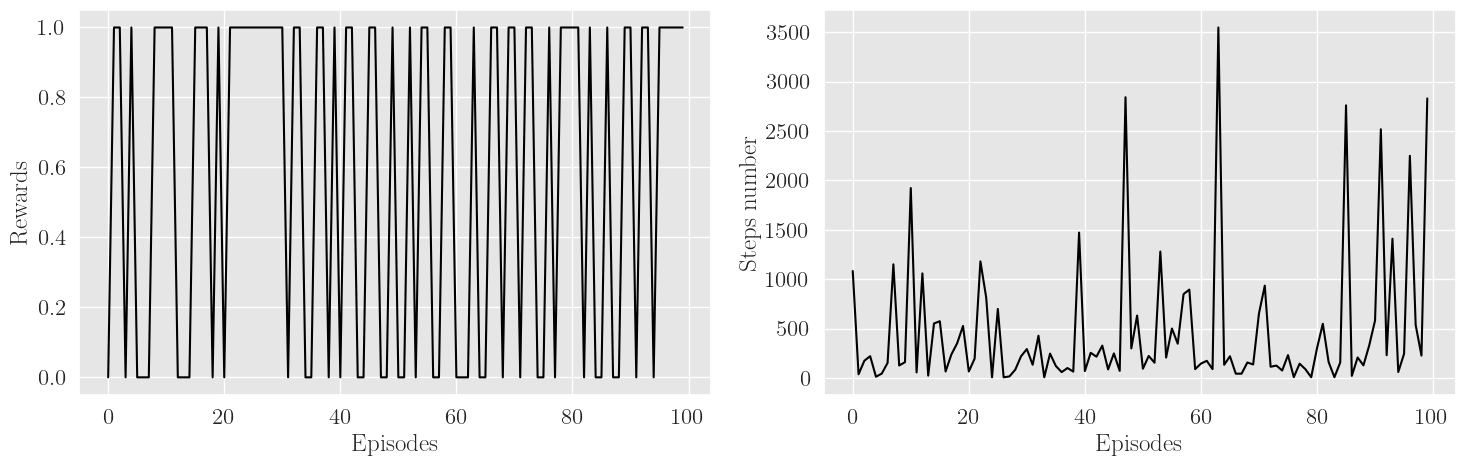

In [25]:
viz.plot_steps_and_rewards(
    rew_steps_df, n_runs=n_runs
)

# Debug

## Initial conditions

In [24]:
explorer.epsilon

1.0

In [25]:
state = env.reset()  # Reset the environment
state = state.clone().float().detach().to(DEVICE)
state

tensor([ 0.0000e+00,  2.0000e+00,  3.0000e+00,  8.7423e-08,  1.0000e+00,
         2.0000e+00,  1.0000e+00, -8.7423e-08, -1.0000e+00,  3.6056e+00,
         5.5470e-01,  8.3205e-01,  8.3205e-01,  5.5470e-01,  2.2361e+00,
         8.9443e-01,  4.4721e-01, -4.4721e-01, -8.9443e-01])

In [26]:
env.TriangleState

<TriangleState.lower: 2>

In [27]:
env.odor_condition

<OdorCondition.pre: 1>

In [28]:
env.odor_ID

<Cues.OdorB: 2>

## Create tensor

In [29]:
dict_state = env.conv_flat_duplicated_coords_to_dict(state)
Cues(dict_state["cue"].item()), dict_state["direction"], dict_state["x"], dict_state["y"]

(<Cues.NoOdor: 0>, tensor([180.0000]), tensor([0.]), tensor([-1.]))

In [30]:
dict_state["x"] = torch.tensor([2])
dict_state["y"] = torch.tensor([1])
dict_state["x"], dict_state["y"]

(tensor([2]), tensor([1]))

In [31]:
conv_state = env.conv_dict_to_flat_duplicated_coords(dict_state)
conv_state

tensor([ 0.0000e+00,  0.0000e+00,  1.0000e+00,  3.2584e-07,  1.0000e+00,
         4.0000e+00,  3.0000e+00, -3.2584e-07, -1.0000e+00,  1.0000e+00,
        -4.3711e-08,  1.0000e+00,  1.0000e+00, -3.5763e-07,  5.0000e+00,
         8.0000e-01,  6.0000e-01, -6.0000e-01, -8.0000e-01])

In [32]:
state_ablated = ablate_state(state=conv_state, keep=keep, silence=silence)
state_ablated

tensor([ 0.0000e+00,  0.0000e+00,  1.0000e+00,  3.2584e-07,  1.0000e+00,
         4.0000e+00,  3.0000e+00, -3.2584e-07, -1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00])

In [33]:
# dict_state_ablated = env.conv_flat_duplicated_coords_to_dict(state_ablated)
# Cues(dict_state_ablated["cue"].item()), dict_state_ablated["direction"], dict_state_ablated["x"], dict_state_ablated["y"]

In [34]:
state_action_values = net(state_ablated).to(DEVICE)  # Q(s_t)
state_action_values

tensor([0.6642, 0.6510, 0.5984], grad_fn=<ViewBackward0>)

In [35]:
Actions(state_action_values.argmax().item())

<Actions.forward: 0>

In [36]:
# action = explorer.choose_action(
#     action_space=env.action_space,
#     state=state,
#     state_action_values=state_action_values,
# ).item()
# action

In [37]:
next_state, reward, done = env.step(action=action, current_state=state)
next_state, reward, done 

(tensor([ 0.0000e+00,  1.0000e+00,  3.0000e+00, -1.0000e+00,  4.3711e-08,
          3.0000e+00,  1.0000e+00,  1.0000e+00, -4.3711e-08,  3.1623e+00,
          3.1623e-01,  9.4868e-01, -3.1623e-01,  9.4868e-01,  3.1623e+00,
          9.4868e-01,  3.1623e-01,  9.4868e-01, -3.1623e-01]),
 tensor([0.]),
 False)

In [38]:
dict_next_state = env.conv_flat_duplicated_coords_to_dict(next_state)
Cues(dict_next_state["cue"].item()), dict_next_state["direction"], dict_next_state["x"], dict_next_state["y"]

(<Cues.NoOdor: 0>, tensor([90.]), tensor([1.]), tensor([-1.]))

In [39]:
next_state = ablate_state(state=next_state, keep=keep, silence=silence)
next_state

tensor([ 0.0000e+00,  1.0000e+00,  3.0000e+00, -1.0000e+00,  4.3711e-08,
         3.0000e+00,  1.0000e+00,  1.0000e+00, -4.3711e-08,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00])

In [40]:
# Move to the next state
state = next_state

## Debug loop

In [41]:
explorer.epsilon = 0.5
state = env.reset()  # Reset the environment
state = state.clone().float().detach().to(DEVICE)
print(env.TriangleState)
print(env.odor_ID)

for istep in tqdm(range(10)):
    print(Cues(dict_state["cue"].item()), dict_state["direction"], dict_state["x"], dict_state["y"])
    state_action_values = net(ablate_state(state=state, keep=keep, silence=silence)).to(DEVICE)  # Q(s_t)
    action = explorer.choose_action(
        action_space=env.action_space,
        state=state,
        state_action_values=state_action_values,
    ).item()
    next_state, reward, done = env.step(action=action, current_state=state)

    print(env.odor_condition)
    
    if done:
        print("Done!")
        break

    state = next_state

TriangleState.upper
Cues.OdorA


  0%|          | 0/10 [00:00<?, ?it/s]

Cues.NoOdor tensor([180.0000]) tensor([2]) tensor([1])
OdorCondition.pre
Cues.NoOdor tensor([180.0000]) tensor([2]) tensor([1])
OdorCondition.pre
Cues.NoOdor tensor([180.0000]) tensor([2]) tensor([1])
OdorCondition.post
Cues.NoOdor tensor([180.0000]) tensor([2]) tensor([1])
OdorCondition.post
Cues.NoOdor tensor([180.0000]) tensor([2]) tensor([1])
OdorCondition.post
Cues.NoOdor tensor([180.0000]) tensor([2]) tensor([1])
OdorCondition.post
Cues.NoOdor tensor([180.0000]) tensor([2]) tensor([1])
OdorCondition.post
Cues.NoOdor tensor([180.0000]) tensor([2]) tensor([1])
OdorCondition.post
Cues.NoOdor tensor([180.0000]) tensor([2]) tensor([1])
OdorCondition.post
Cues.NoOdor tensor([180.0000]) tensor([2]) tensor([1])
OdorCondition.post
